In [1]:
import numpy as np
import os
import random
import torch

from torch.utils.data import DataLoader, random_split
from torchvision import transforms

from Callbacks import EarlyStopping
from TransferLearningModel import TransferLearningModel
from utils import DicomFineDataset3D, TransformDataset, TransformDatasetBalanced, TensorFolderDataset, find_overlapping_images_3d

In [2]:
data_augmentation = True
save_folder_base = "./data/fine_3d"

In [3]:
BASE_DIR = "C:/Users/Dominik Hahn/OneDrive/Studium/Master/Masterarbeit/Daten/nodule"
# BASE_DIR = "C:/Users/domin/OneDrive/Studium/Master/Masterarbeit/Daten"
seed = 41
batch_size = 32
image_size = 80 #best yet 80 with 87%
classes = ["A", "B", "E", "G"]
train_ratio = 0.6

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

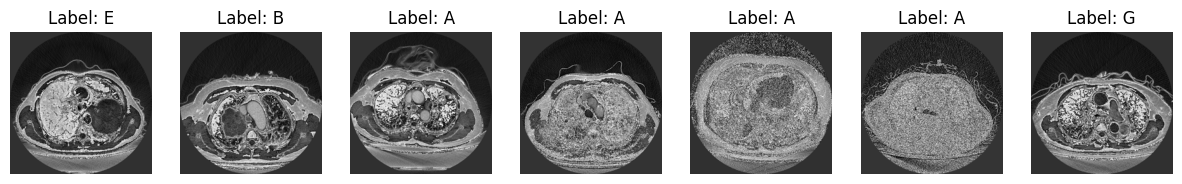

In [4]:
classes_dict = {value: index for index, value in enumerate(classes)}
dataset = DicomFineDataset3D(root_dir=BASE_DIR, classes=classes)
# dataset = DicomCoarseDataset3D(root_dir=BASE_DIR, num_images_per_class=100, classes=classes, scenario=1)
dataset.visualize_volumes(num_volumes=7)

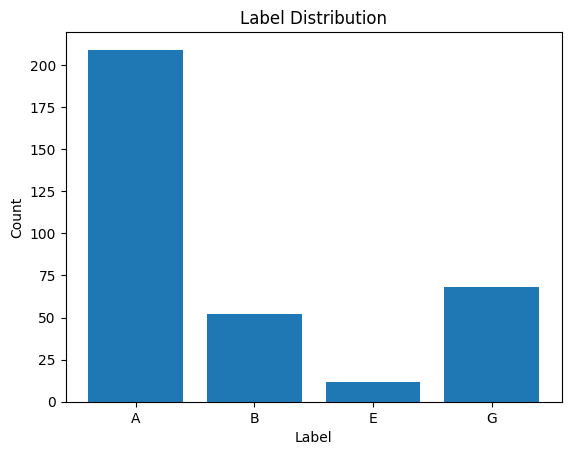

In [5]:
dataset.display_label_distribution()

c:\Users\Dominik Hahn\Documents\GitHub\Masterarbeit\Final Models\utils.py:551: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(file_path)


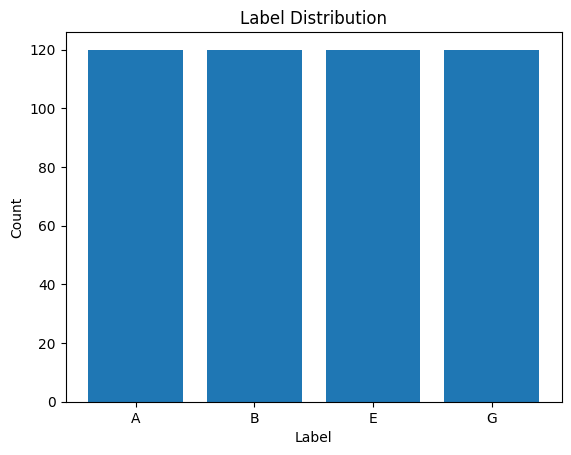

In [6]:
train_dataset_base = TensorFolderDataset(os.path.join(save_folder_base, "train"))
val_dataset_base = TensorFolderDataset(os.path.join(save_folder_base, "val"))
test_dataset_base = TensorFolderDataset(os.path.join(save_folder_base, "test"))

train_dataset = TransformDatasetBalanced(train_dataset_base, classes=classes_dict)
train_dataset.display_label_distribution()

In [7]:
val_dataset = TransformDataset(val_dataset_base)
test_dataset = TransformDataset(test_dataset_base)

find_overlapping_images_3d(train_dataset, val_dataset)
find_overlapping_images_3d(train_dataset, test_dataset)

c:\Users\Dominik Hahn\Documents\GitHub\Masterarbeit\Final Models\utils.py:551: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(file_path)


Found 0 overlapping images
Found 0 overlapping images


[]

Processing model: 3D-CNN


c:\Users\Dominik Hahn\Documents\GitHub\Masterarbeit\Final Models\utils.py:551: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(file_path)


Train size upsampled: 480 --- Validation size upsampled: 184 --- Test size upsampled: 69
Epoch 1/50 ----- Loss: 1.1440, Accuracy: 58.12% ----- Validation Loss: 6.9781, Validation Accuracy: 25.00%
Epoch 2/50 ----- Loss: 0.8011, Accuracy: 68.54% ----- Validation Loss: 1.7903, Validation Accuracy: 55.43%
Epoch 3/50 ----- Loss: 0.6495, Accuracy: 75.42% ----- Validation Loss: 0.7409, Validation Accuracy: 69.02%
Epoch 4/50 ----- Loss: 0.6277, Accuracy: 76.46% ----- Validation Loss: 0.5989, Validation Accuracy: 78.80%
Epoch 5/50 ----- Loss: 0.5749, Accuracy: 77.92% ----- Validation Loss: 0.5550, Validation Accuracy: 77.72%
Epoch 6/50 ----- Loss: 0.5483, Accuracy: 78.33% ----- Validation Loss: 0.5111, Validation Accuracy: 88.04%
Epoch 7/50 ----- Loss: 0.4469, Accuracy: 84.17% ----- Validation Loss: 0.4181, Validation Accuracy: 87.50%
Epoch 8/50 ----- Loss: 0.3827, Accuracy: 89.79% ----- Validation Loss: 0.3805, Validation Accuracy: 88.04%
Epoch 9/50 ----- Loss: 0.3525, Accuracy: 89.79% ----- V

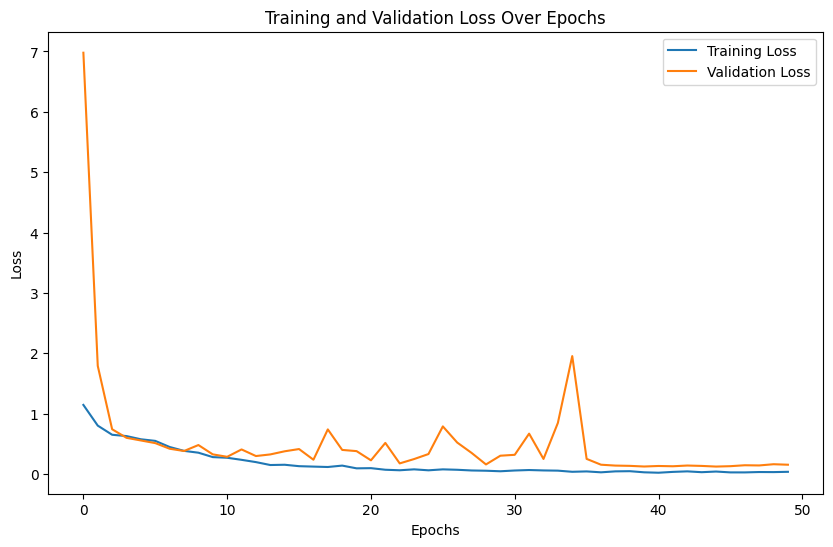

In [11]:
print("Processing model: 3D-CNN")
model = TransferLearningModel(classes, "3dcnn", data_augmentation=data_augmentation, fine=True)

# Ensure transforms are correctly applied based on model requirements
model.train_transforms, model.test_transforms = model.get_transforms()

# Apply specific transforms to each subset
train_dataset = TransformDatasetBalanced(train_dataset_base, classes=classes_dict, transform=model.train_transforms)
val_dataset = TransformDatasetBalanced(val_dataset_base, classes=classes_dict, transform=model.test_transforms)
test_dataset = TransformDataset(test_dataset_base, transform=model.test_transforms)

print(f"Train size upsampled: {len(train_dataset)} --- Validation size upsampled: {len(val_dataset)} --- Test size upsampled: {len(test_dataset)}")

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Initialize early stopping
early_stopping = EarlyStopping(patience=10)

# Train the current model
model.train(train_loader, val_loader, early_stopping, epochs=50)

0.12276648503282796


c:\Users\Dominik Hahn\Documents\GitHub\Masterarbeit\Final Models\utils.py:551: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(file_path)


Evaluation Accuracy on unseen data: 86.95652173913044


<Figure size 1000x800 with 0 Axes>

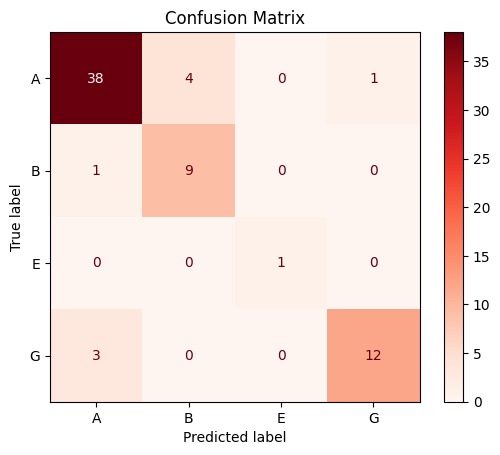

In [13]:
checkpoint = torch.load(f"weights/fine/augmented_{model.model_name}.pt", weights_only=False)
model.model.load_state_dict(checkpoint['model_state_dict'])
loss = checkpoint["loss"]
print(loss)
model.evaluate(test_loader)